In [4]:
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split

import pandas as pd 
import random 
import numpy as np 
from torch import nn, optim 
import torch 

from torch.utils.data import Dataset, DataLoader

## Build Class

In [5]:
class NeuMF(nn.Module):
    def __init__(self, args):
        super(NeuMF, self).__init__()

        self.num_users = args.num_users 
        self.num_items = args.num_items
        self.latent_dim = args.latent_dim

        self.mf_user_emb = nn.Embedding(self.num_users, self.latent_dim)
        self.mf_item_emb = nn.Embedding(self.num_items, self.latent_dim)

        self.mlp_user_emb = nn.Embedding(self.num_users, self.latent_dim)
        self.mlp_item_emb = nn.Embedding(self.num_items, self.latent_dim)

        self.mlp_layer = nn.Sequential(
            nn.Linear(2*self.latent_dim, self.latent_dim), 
            nn.ReLU(), 
            nn.Linear(self.latent_dim, self.latent_dim//2), 
            nn.ReLU(), 
            nn.Linear(self.latent_dim//2, self.latent_dim//4)
        )
        self.fc_layer = nn.Linear(self.latent_dim//4 + self.latent_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, uid, iid):
        mf_user_emb = self.mf_user_emb(uid)
        mf_item_emb = self.mf_item_emb(iid)

        mlp_user_emb = self.mlp_user_emb(uid)
        mlp_item_emb = self.mlp_item_emb(iid)

        mf_outputs = torch.mul(mf_user_emb, mf_item_emb)

        mlp_inputs = torch.concat([mlp_user_emb, mlp_item_emb], axis = 1)
        mlp_outputs = self.mlp_layer(mlp_inputs)

        outputs = torch.concat([mlp_outputs, mf_outputs], axis=1)
        outputs = self.fc_layer(outputs)
        outputs = self.sigmoid(outputs)
        return outputs 

In [6]:
def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

In [7]:
class MFDataset(Dataset):
    def __init__(self, dataframe):
        self.user_id = dataframe.user_id
        self.item_id = dataframe.business_id
        self.labels = dataframe.stars 

    def __len__(self):
        return len(self.user_id)

    def __getitem__(self, idx):
        uid = self.user_id[idx]
        iid = self.item_id[idx]
        label = self.labels[idx]

        return (
            torch.tensor(uid, dtype=torch.long), 
            torch.tensor(iid, dtype=torch.long), 
            torch.tensor(label, dtype=torch.float)
        )


In [8]:
def sentiment_score(x):
    if x >= 3.5 : return 1
    elif x < 3.5 : return 0
    
def train(args, model, train_loader, test_loader, optimizer, criterion):
    train_losses = []
    valid_losses = []
    best_loss = float('inf')

    set_seed(args)
    model = model.to(args.device)
    model.train()
    for epoch in tqdm(range(1, args.num_epochs + 1)):
        train_loss, valid_loss = 0.0, 0.0

        for batch in train_loader:
            batch = tuple(b.to(args.device) for b in batch)

            inputs = {'uid':    batch[0], 
                      'iid':    batch[1]}
            gold_y = batch[2]

            pred_y = model(**inputs).squeeze()
            loss = criterion(pred_y, gold_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        train_losses.append(train_loss)

        valid_loss = evaluate(args, model, test_loader, criterion)
        valid_losses.append(valid_loss)

        if epoch % 10 == 0 :
            print(f'Epoch: [{epoch}/{args.num_epochs}]')
            print(f'Train Loss: {train_loss:.5f}')
            print(f'Valid Loss: {valid_loss:.5f}')

        if best_loss > valid_loss:
            best_loss = valid_loss
            if not os.path.exists(args.SAVE_PATH):
                os.makedirs(args.SAVE_PATH)
            torch.save(model.state_dict(), os.path.join(args.SAVE_PATH, f'{model._get_name()}_parameters.pt'))
    
    return {
        'train_loss': train_losses, 
        'valid_loss': valid_losses
    }


def evaluate(args, model, test_loader, criterion):
    losses = 0
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(b.to(args.device) for b in batch)

            inputs = {'uid':    batch[0], 
                      'iid':    batch[1]}
            gold_y = batch[2]

            pred_y = model(**inputs).squeeze()
                
            loss = criterion(pred_y, gold_y)
        
            losses += loss.item()
        losses /= len(test_loader)
    return losses


In [9]:
class args:
    seed = 42 
    batch_size = 512
    SAVE_PATH = os.path.basename(os.getcwd())
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lr = 1e-3

In [10]:
DATA_PATH = 'data/sample.csv'
d_set = pd.read_csv(DATA_PATH, encoding='utf-8-sig')

d_set = d_set.astype({'user_id':'category', 'business_id':'category'})

d_set.stars = d_set.stars.apply(sentiment_score)

In [11]:
d_train, d_test = train_test_split(d_set, train_size=0.8, random_state=args.seed)
d_valid, d_test = train_test_split(d_test, train_size=0.5, random_state=args.seed)

In [12]:
u_cat = d_train.user_id.cat.categories
b_cat = d_train.business_id.cat.categories

In [13]:
d_valid.user_id = d_valid.user_id.cat.set_categories(u_cat)
d_valid.business_id = d_valid.business_id.cat.set_categories(b_cat)

d_test.user_id = d_test.user_id.cat.set_categories(u_cat)
d_test.business_id = d_test.business_id.cat.set_categories(b_cat)

In [14]:
d_train.user_id = d_train.user_id.cat.codes
d_train.business_id = d_train.business_id.cat.codes 

d_valid.user_id = d_valid.user_id.cat.codes
d_valid.business_id = d_valid.business_id.cat.codes 

d_test.user_id = d_test.user_id.cat.codes
d_test.business_id = d_test.business_id.cat.codes 

In [15]:
d_train = d_train.dropna()
d_valid = d_valid.dropna()
d_test = d_test.dropna()

d_train.reset_index(drop=True, inplace=True)
d_valid.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

In [16]:
args.num_users = d_train.user_id.max() + 1
args.num_items = d_train.business_id.max() + 1
args.latent_dim = 64
args.num_epochs = 10

In [17]:
model = NeuMF(args)

train_set = MFDataset(d_train)
valid_set = MFDataset(d_valid)
test_set = MFDataset(d_test)

train_loader = DataLoader(train_set, batch_size=args.batch_size, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=args.batch_size, num_workers=4)
test_loader = DataLoader(test_set, batch_size=args.batch_size, num_workers=4)

optimizer = optim.Adam(model.parameters(), lr=args.lr)
criterion = nn.BCELoss()

In [18]:
losses = train(args, model, train_loader, valid_loader, optimizer, criterion)

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

Epoch: [10/10]
Train Loss: 0.12960
Valid Loss: 1.17288


In [19]:
test_loss = evaluate(args, model, test_loader, criterion)

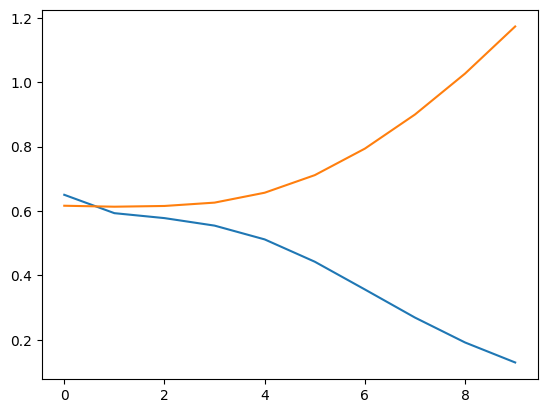

In [20]:
import matplotlib.pyplot as plt 

train_losses = losses['train_loss']
valid_losses = losses['valid_loss']

length = range(train_losses.__len__())

plt.plot(length, train_losses, '-')
plt.plot(length, valid_losses, '-')
plt.show()